<a href="https://colab.research.google.com/github/QasimKhan5x/Evaluation-Exercise/blob/main/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install fastai --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

On close inspection of the dataset, I learnt that multiple columns - from event ID to obj1 - were squeezed inside one column in the .csv file. Therefore, all the values between semicolons in the first column of the dataset need to be split.

In [3]:
fp = '/content/monojet_Zp2000.0_DM_50.0_chan3.csv'
data = []
with open(fp, 'r') as f:
    # all columns need to be separated by a comma
    # to represent a .csv file
    for line in f.readlines():
        # there are a variable number of columns so we need to remove
        # the ones that are empty from each string by stripping the ending commas
        data.append(line.replace(';', ',').rstrip(',\n').split(','))
data[0]

['354',
 'monojet_Zp2000.0_DM_50.0',
 '2.44336e-05',
 '832841',
 '-1.22431',
 'b',
 '947383',
 '824498',
 '-0.523103',
 '1.64421',
 'j',
 '258722',
 '243675',
 '0.328962',
 '2.25014',
 'j',
 '520092',
 '108590',
 '-2.2473',
 '-1.85679',
 'j',
 '383024',
 '88405.6',
 '2.14516',
 '-1.95635',
 'j',
 '39507.6',
 '35365.1',
 '0.47046',
 '-1.16445',
 'j',
 '225430',
 '26878.2',
 '-2.81608',
 '-2.25938']

In [4]:
len(data)

6399

In [5]:
# To convert it into a pandas dataframe, we need to know the number of columns
n_cols = len(max(data, key=len))
n_cols

65

In [6]:
# prepare columns for dataframe
meta_cols = ['event ID', 'process ID', 'event weight', 'MET', 'METphi']
particle_cols = ['obj', 'E', 'pt', 'eta', 'phi']
columns = meta_cols[:]
for i in range(n_cols - 5):
    columns.append(f'{particle_cols[i % 5]}{i // 5 + 1}')
len(columns)

65

In [7]:
particles = pd.DataFrame(data, columns=columns)
particles

,event ID,process ID,event weight,MET,METphi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12
0,354,monojet_Zp2000.0_DM_50.0,2.44336e-05,832841,-1.22431,b,947383,824498,-0.523103,1.64421,j,258722,243675,0.328962,2.25014,j,520092,108590,-2.2473,-1.85679,j,383024,88405.6,2.14516,-1.95635,j,39507.6,35365.1,0.47046,-1.16445,j,225430,26878.2,-2.81608,-2.25938,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,354,monojet_Zp2000.0_DM_50.0,2.44336e-05,732115,1.17245,j,1.07E+06,751597,0.858186,-1.84217,j,457647,110079,2.10287,2.17501,j,49649.1,30875.2,-1.03189,-1.7992,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,354,monojet_Zp2000.0_DM_50.0,2.44336e-05,1.05628e+06,-3.06744,j,676000,640429,0.33045,0.704554,j,1.24E+06,602104,1.34324,-0.550856,j,193865,44825.7,-2.14231,-0.965933,j,28217.2,24926.6,-0.454264,0.516676,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,354,monojet_Zp2000.0_DM_50.0,2.44336e-05,631781,1.64181,j,936707,616229,0.973383,-1.56592,j,75998,52304.3,0.905489,-0.806736,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,354,monojet_Zp2000.0_DM_50.0,2.44336e-05,457316,-1.87536,j,640313,589524,0.390749,1.23734,j,332790,126272,1.61998,-1.85524,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6394,354,monojet_Zp2000.0_DM_50.0,2.44336e-05,914355,1.52903,j,1.12E+06,1.01E+06,0.453265,-1.77278,b,246762,95229.6,1.60511,-0.520258,j,402070,77864.5,2.32445,0.92948,j,74709.2,69979.3,0.359168,0.94458,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6395,354,monojet_Zp2000.0_DM_50.0,2.44336e-05,782256,-1.20751,j,1.92E+06,874869,1.41855,1.83927,j,156224,152161,-0.222571,-1.83395,j,102296,64861.3,1.02478,0.412515,j,421972,37149.5,-3.12086,2.50949,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6396,354,monojet_Zp2000.0_DM_50.0,2.44336e-05,645619,-2.48399,j,787964,263158,1.75981,0.456786,j,408087,258903,-1.0269,1.53073,j,1.43E+06,204716,-2.63018,-0.253528,j,75924.4,63520.6,-0.586197,0.84639,j,54710.9,47683.2,0.527799,-1.58165,j,173678,45568.1,-2.01196,1.10735,j,170938,28409.1,-2.47968,2.38334,j,43035.2,26973.3,-1.02803,0.105967,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6397,354,monojet_Zp2000.0_DM_50.0,2.44336e-05,632390,-0.975687,j,731849,722541,-0.134499,2.56393,j,268828,259144,0.153813,0.578428,j,153340,43931.5,1.92014,-0.237382,None,None,None,None,None,None,None,None,None,Non

We do not need the first 5 columns since a particle can by identified by the following only:

obj, E, pt, eta, phi

Moreover, we only need the jet particles identified by the first object (obj1)

In [8]:
particles.drop(meta_cols, axis=1, inplace=True)
jets = particles.loc[:, 'obj1':'phi1']
jets = jets.reset_index(drop=True)
jets

,obj1,E1,pt1,eta1,phi1
0,b,947383,824498,-0.523103,1.64421
1,j,1.07E+06,751597,0.858186,-1.84217
2,j,676000,640429,0.33045,0.704554
3,j,936707,616229,0.973383,-1.56592
4,j,640313,589524,0.390749,1.23734
...,...,...,...,...,...
6394,j,1.12E+06,1.01E+06,0.453265,-1.77278
6395,j,1.92E+06,874869,1.41855,1.83927
6396,j,787964,263158,1.75981,0.456786
6397,j,731849,722541,-0.134499,2.56393


Let's remove the b-jets from the data.

In [9]:
keep = jets['obj1'] == 'j'
jets = jets[keep]
jets.reset_index(inplace=True, drop=True)
jets.head()

,obj1,E1,pt1,eta1,phi1
0,j,1.07E+06,751597,0.858186,-1.84217
1,j,676000,640429,0.33045,0.704554
2,j,936707,616229,0.973383,-1.56592
3,j,640313,589524,0.390749,1.23734
4,j,583373,545730,0.364057,-1.60732


In [10]:
jets.shape

(6202, 5)

In [11]:
jets.isna().sum()

obj1    0
E1      0
pt1     0
eta1    0
phi1    0
dtype: int64

In [12]:
jets.drop('obj1', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
jets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6202 entries, 0 to 6201
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E1      6202 non-null   object
 1   pt1     6202 non-null   object
 2   eta1    6202 non-null   object
 3   phi1    6202 non-null   object
dtypes: object(4)
memory usage: 193.9+ KB


In [14]:
jets = jets.apply(pd.to_numeric)
jets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6202 entries, 0 to 6201
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   E1      6202 non-null   float64
 1   pt1     6202 non-null   float64
 2   eta1    6202 non-null   float64
 3   phi1    6202 non-null   float64
dtypes: float64(4)
memory usage: 193.9 KB


In [15]:
jets.columns = ['E', 'pt', 'eta', 'phi']

# Normalizaion

From the literature that I have consulted, this project uses different normalization techniques such as
1. Standardization
2. Normalization to [-1, 1]
3. Custom normalization done by 
Wulff, E.. (2020). Deep Autoencoders for Compression in High Energy Physics.

The example notebook provided in Google Classroom seems to have used Custom Normalization.



#### Standardization

In [16]:
jets_standard = (jets - jets.mean()) / jets.std()
jets_standard.describe()

,E,pt,eta,phi
count,6.202000e+03,6.202000e+03,6.202000e+03,6.202000e+03
mean,1.002101e-16,-1.537700e-16,1.441034e-17,-3.938231e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.609910e+00,-1.817817e+00,-3.486065e+00,-1.750138e+00
25%,-6.869198e-01,-7.115470e-01,-7.012199e-01,-8.584320e-01
50%,-2.251912e-01,-1.564392e-01,-1.368963e-02,2.128107e-02
75%,4.114723e-01,4.917125e-01,7.056039e-01,8.431261e-01
max,8.309600e+00,6.013718e+00,2.992884e+00,1.744344e+00


#### Formula for Normalization to [-1, 1]

$x^` = 2 \frac{x - min(x)}{max(x) - min(x)} - 1$*italicized text*

In [17]:
jets11 = 2 * ((jets - jets.min()) / (jets.max() - jets.min())) - 1
jets11.describe()

,E,pt,eta,phi
count,6202.000000,6202.000000,6202.000000,6202.000000
mean,-0.675405,-0.535770,0.076121,0.001658
std,0.201623,0.255378,0.308692,0.572331
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.813904,-0.717483,-0.140340,-0.489649
50%,-0.720809,-0.575721,0.071895,0.013838
75%,-0.592443,-0.410197,0.293935,0.484205
max,1.000000,1.000000,1.000000,1.000000


#### Formula for Custom Normalization

pt $\longrightarrow \log _{10}pt$

E $ \longrightarrow \log _{10}E$

eta $\longrightarrow eta / 3 $

phi $\longrightarrow phi / 3$

In [18]:
jets_custom = jets.copy()
jets_custom['pt'] = np.log10(jets_custom['pt'])
jets_custom['E'] = np.log10(jets_custom['E'])
jets_custom['eta'] = jets_custom['eta'] / 3
jets_custom['phi'] = jets_custom['phi'] / 3
jets_custom.describe()

,E,pt,eta,phi
count,6202.000000,6202.000000,6202.000000,6202.000000
mean,5.870721,5.734099,0.001076,0.001369
std,0.206140,0.178313,0.294169,0.599089
min,5.145607,5.133028,-1.024417,-1.047120
25%,5.730105,5.614772,-0.205201,-0.512908
50%,5.866835,5.740674,-0.002951,0.014118
75%,6.004321,5.852556,0.208643,0.506477
max,6.644439,6.320146,0.881490,1.046387


### Visualize Normalization

In [61]:
def plot_hist(df, title, unit_list=['[GeV]', '[rad]', '[rad]', '[GeV]']):

    variable_list= [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
    fig = plt.figure(figsize=(10, 8))
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    branches=["pt","eta","phi","E"]
    n_bins = 100
    for kk in range(4):
        plt.subplot(220 + kk + 1)
        n_hist_data, bin_edges, _ = plt.hist(df[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
        plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
        plt.ylabel('# of events')

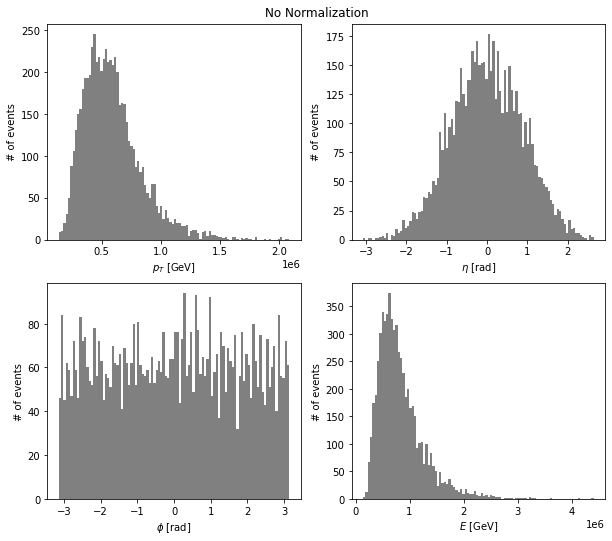

In [66]:
plot_hist(jets, 'No Normalization')

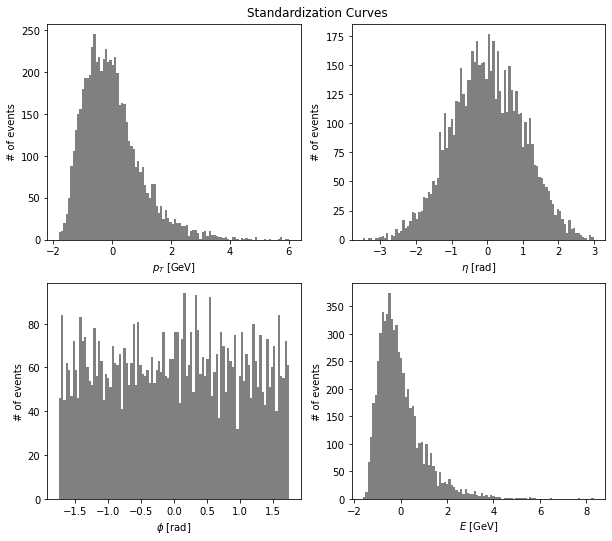

In [62]:
plot_hist(jets_standard, 'Standardization Curves')

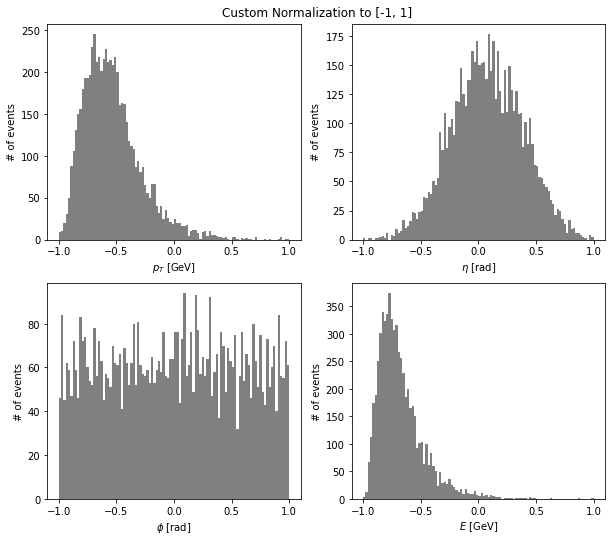

In [63]:
plot_hist(jets11, 'Custom Normalization to [-1, 1]')

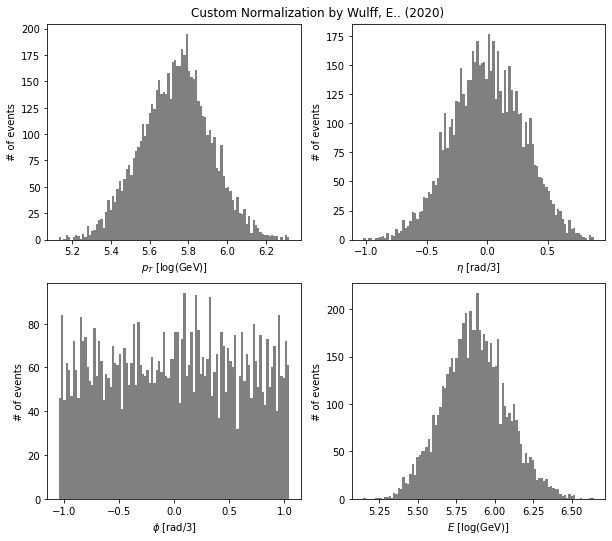

In [64]:
units = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
plot_hist(jets_custom, 'Custom Normalization by Wulff, E.. (2020)', units)

The least amount of skewness is present in the custom normalization. 
Therefore, I will use the custom normalization for compression.

# Compression using AE

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(jets, test_size=0.2)

In [26]:
def normalize_custom(df):
    # perform custon normalization
    df.loc[:, 'pt'] = np.log10(df['pt'])
    df.loc[:, 'E'] = np.log10(df['E'])
    df.loc[:, 'eta'] = df['eta'] / 3
    df.loc[:, 'phi'] = df['phi'] / 3

    return df

In [27]:
X_train, X_valid = normalize_custom(X_train), normalize_custom(X_valid)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [28]:
X_train.head()

,E,pt,eta,phi
5550,5.815087,5.771049,-0.145546,-0.768317
35,6.309630,6.075547,-0.378847,-0.258129
3786,5.957511,5.867313,-0.221385,0.653707
5629,5.808205,5.458676,0.481047,0.041548
3334,5.936855,5.458993,-0.587927,-0.138188


In [29]:
# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(X_train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(X_valid.values, dtype=torch.float), torch.tensor(X_valid.values, dtype=torch.float))

In [30]:
len(train_ds), len(valid_ds)

(4961, 1241)

In [31]:
bs = 128

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

In [32]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [33]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

Learning rate with the minimum loss: 0.014454397559165954
Learning rate with the steepest gradient: 0.002511886414140463


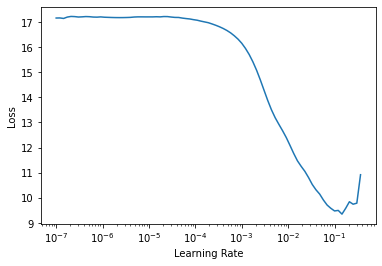

In [34]:
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [35]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')
# Training took 83.10589644300035 seconds

[0, 1.83197021484375, 0.20217271149158478, '00:00']
[0, 1.83197021484375, 0.20217271149158478, '00:00']
[1, 0.43864551186561584, 0.13582170009613037, '00:00']
[1, 0.43864551186561584, 0.13582170009613037, '00:00']
[2, 0.19289569556713104, 0.1304943561553955, '00:00']
[2, 0.19289569556713104, 0.1304943561553955, '00:00']
[3, 0.1458108127117157, 0.12978535890579224, '00:00']
[3, 0.1458108127117157, 0.12978535890579224, '00:00']
[4, 0.1358467936515808, 0.13928627967834473, '00:00']
[4, 0.1358467936515808, 0.13928627967834473, '00:00']
[5, 0.1361970603466034, 0.13450807332992554, '00:00']
[5, 0.1361970603466034, 0.13450807332992554, '00:00']
[6, 0.1345929503440857, 0.134489968419075, '00:00']
[6, 0.1345929503440857, 0.134489968419075, '00:00']
[7, 0.07747820019721985, 0.04219464585185051, '00:00']
[7, 0.07747820019721985, 0.04219464585185051, '00:00']
[8, 0.05226226523518562, 0.04380810260772705, '00:00']
[8, 0.05226226523518562, 0.04380810260772705, '00:00']
[9, 0.0463397242128849, 0.0455

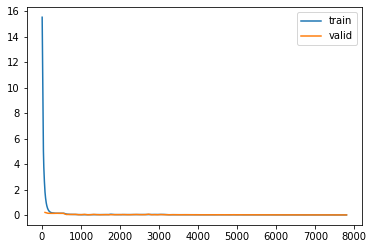

In [36]:
recorder.plot_loss()

In [37]:
learn.validate()

(#1) [0.00827698316425085]

In [38]:
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [39]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**df['E']
    df['pt'] = 10**(df['pt'])
    
    return df

In [41]:
def plot_compression(df):
    plt.close('all')
    unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
    variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
    line_style = ['--', '-']
    colors = ['orange', 'c']
    markers = ['*', 's']

    model.to('cpu')

    save = True # Option to save figure

    # Histograms
    idxs = (0, 100000)  # Choose events to compare
    data = torch.tensor(X_valid[idxs[0]:idxs[1]].values, dtype=torch.float)
    pred = model(data)
    pred = pred.detach().numpy()
    data = data.detach().numpy()

    data_df = pd.DataFrame(data, columns=df.columns)
    pred_df = pd.DataFrame(pred, columns=df.columns)

    unnormalized_data_df = custom_unnormalize(data_df)
    unnormalized_pred_df = custom_unnormalize(pred_df)    
        
    alph = 0.8
    n_bins = 200
    plt.figure(figsize=(10, 8))
    for kk in np.arange(4):
        plt.subplot(220 + kk + 1)
        n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
        n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
        plt.suptitle(df.columns[kk])
        plt.xlabel(df.columns[kk])
        plt.ylabel('Number of events')
        # ms.sciy()
        plt.yscale('log')
        if save:
            plt.savefig(os.path.join(save_dir,df.columns[kk]+'.png'))
        plt.legend()

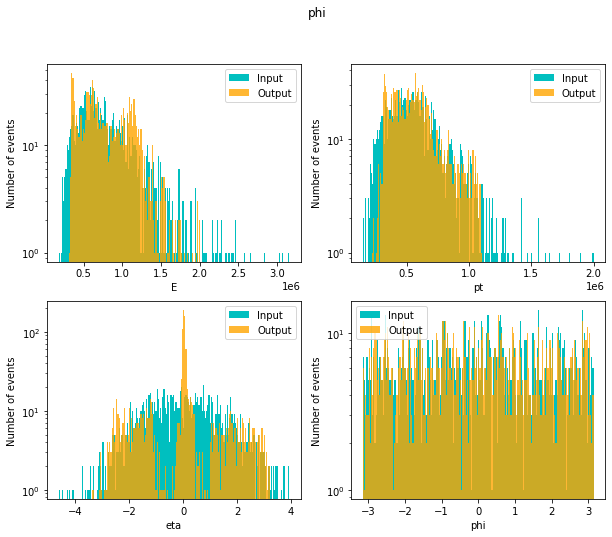

In [42]:
plot_compression(X_train)

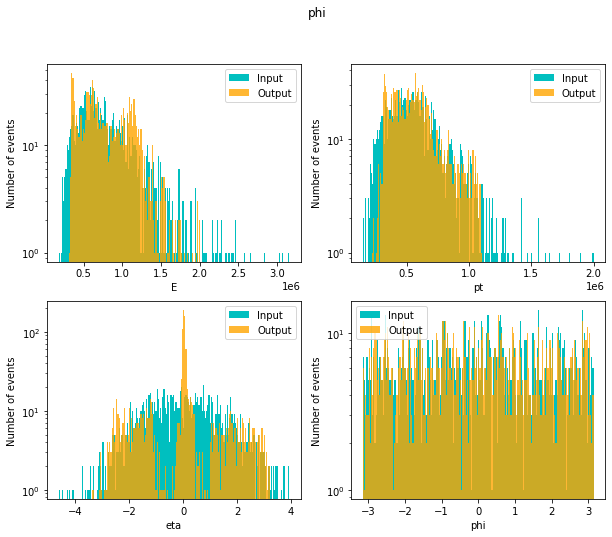

In [43]:
plot_compression(X_valid)